# OpenDC Reproducibility Capsule Tool
**Version:** 1.0.0

Welcome to OpenDC reproducibility capsule. This capsule aims to foster reproducible research practices and aid researchers in automatically making reproducible experiments.
The capsule consists of three main parts: ```Topology Generation```, ```Experiment Generation, Running and exporting```. Each section is preceded by instructions on how to use it.

In [1]:
#Imports:
import ipywidgets as widgets
from IPython.display import display
import shutil
from pathlib import Path
from src.summary_generator import *
from src.template_loader import *
from src.topology_generator import *
from src.experiment_generator import *
from src.runner import *
from src.exporter import *
from src.utils import *
from src.validator import *


c:\Users\37067\OneDrive\Desktop\Domas\VU\reproducibility_experiments\reproducibility_experiment1\reproducibility_capsule\src\runner.py:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if result.stderr is not "":


# Run all experiments
To run all of the experiments click the ```Run all experiments``` button below. This is intended for the result verfication of the capsule, for this purpose rerun experiments are renamed repr_original name to distinguish from original. You can also validate whether the reproduced files match the original by clicking button ```Compare outputs```.

In [2]:
run_all_experiments_button = widgets.Button(description="Run all experiments")
output_run_all = widgets.Output()

compare_results_button = widgets.Button(description="Compare outputs")
output_comparison = widgets.Output()


def on_run_everything_clicked(b):
    with output_run_all:
        output_run_all.clear_output()
        all_experiments = []

        for rel in list_files("experiments"):
            original = Path("experiments") / rel

            name_no_ext = original.stem
            repr_name = f"repr_{name_no_ext}"
            repr_rel = Path(rel).with_name(repr_name + ".json")
            repr_full = Path("experiments") / repr_rel

            repr_full.parent.mkdir(parents=True, exist_ok=True)
            shutil.copyfile(original, repr_full)

            
            data = json.loads(repr_full.read_text())
            rel_folder = repr_rel.with_suffix("")
            data["name"] = rel_folder.as_posix()
            repr_full.write_text(json.dumps(data, indent=4))
            

            all_experiments.append({"name": repr_rel.as_posix()})

        print(f"Running {len(all_experiments)} reproducibility experiments...")
        run_all_experiments(all_experiments)



def on_compare_clicked(b):
    with output_comparison:
        output_comparison.clear_output()
        compare_all_experiments_outputs()    

run_all_experiments_button.on_click(on_run_everything_clicked)
compare_results_button.on_click(on_compare_clicked)

display(
    run_all_experiments_button,
    output_run_all,
    compare_results_button,
    output_comparison
)

Button(description='Run all experiments', style=ButtonStyle())

Output()

Button(description='Compare outputs', style=ButtonStyle())

Output()

## Topology Generator

This part is used to generate topologies, which define the structure of the data center to be simulated. Below is a quick summary of how to use the UI. You can also call the functions `build_one_topology(...)` or `update_topology_values` (see `src/topology_generator.py` for documentation) directly.

- **Name and Template**: Select a name and a topology template (both are optional). If neither is provided, a new topology with a default name is generated. If a template is selected, user-defined values override those in the template.

- **Value Configuration**: Enter CPU count, speed, and memory size. Supports single values, lists, or ranges (e.g., `4`, `4,8,16`, or `4-16`).

- **Carbon Configuration**: Upload a carbon file or select from existing entries (`[Select All]` to include all). Specify the number of hosts (also accepts single values, lists, or ranges).

- **Battery Configuration**: Enable if needed by checking the box. Provide battery capacity, starting charge, charging speed and expected lifetime. Accepts single values, lists, or ranges.

- **Power Model Configuration**: Choose one power model to apply to all generated topologies. Different models may require different fields (e.g., idle, max, and base power). Only one power model can be chosen and applied to all of the topologies.

- **Generation**: Click **Generate Topology** to produce the output file. You will see indications of what topologies were created.

**Note:**  
No field is mandatory — if a section is left blank, it will not be included in the generated topology. Lists and ranges can be combined for custom distributions (e.g., `1-5:1, 7, 10-15:1`). The generator creates as many topologies as the longest list, skipping values from shorter lists when mismatched by default. To generate all possible combinations tick ```Generate all combinations``` button below the Carbon configuration selector.


In [ ]:
name_selector_topo = widgets.Text(placeholder='Enter topology name', description='Name:', disabled=False)

if os.path.isdir("templates"):
    topo_template_path = "templates/topologies/"
else:
    topo_template_path = "topologies/"

# ---------------Topology Widgets-------------------------------------------------------------------------------------
topology_selector_topo = widgets.Dropdown(options=['[None]'] + list_files(topo_template_path), description='Topology Template:')
topology_upload_topo = widgets.FileUpload(accept='.json', multiple=False, description='Upload Topology')
topology_row_topo = widgets.HBox([topology_selector_topo, topology_upload_topo])

# ---------------Carbon Widgets-------------------------------------------------------------------------------------
carbon_selector = widgets.SelectMultiple(
    options=['[Keep original]'] + ['[Select All]'] + safe_listdir("carbon_traces"),
    description='Carbon:'
)
carbon_upload = widgets.FileUpload(accept='.parquet', multiple=False, description='Upload Carbon Traces')

generate_combinations_checkbox = widgets.Checkbox(
    value=False,
    description='Generate all combinations',
    disabled=False
)
carbon_row = widgets.HBox([carbon_selector, carbon_upload]) 

# ------------------ NoH --------------------------------------------------------------------------------------------
NoH_input = widgets.Text(
    placeholder='Enter number, list or range (e.g. 1, 2, 3 or 1-10:1)',
    description='# Hosts:',
    disabled=False
)

# -----------------Battery Values -----------------------------------------------------------------------------------
battery_capacity_input = widgets.Text(
    value='100',
    placeholder='Enter number, list or range (e.g. 100, 200 or 100-300:50)',
    description='Battery Capacity:',
    disabled=False
)

starting_CI_input = widgets.Text(
    value='0.1',
    placeholder='Enter number, list or range (e.g. 0.1, 0.2)',
    description='Start CI:',
    disabled=False
)

charging_speed_input = widgets.Text(
    value='1000',
    placeholder='Enter number, list or range (e.g. 1000, )',
    description='Charging Speed:',
    disabled=False
)

expected_lifetime_input = widgets.Text(
    value='10',
    placeholder='Enter number, list or range (e.g. 1000, )',
    description='Expected Lifetime:',
    disabled=False
)

add_battery_checkbox = widgets.Checkbox(
    value=False,
    description='Include Battery',
    disabled=False
)

battery_row = widgets.VBox([
    battery_capacity_input,
    starting_CI_input,
    charging_speed_input,
    expected_lifetime_input
])

# ------------------ CPU and Memory Inputs -----------------------------------------------------------------------------------
cpu_count_input = widgets.Text(
    placeholder='Enter number, list or range (e.g. 48, 64, or 32-96:16)',
    description='CPU Count:',
    disabled=False
)

cpu_speed_input = widgets.Text(
    placeholder='Enter number, list or range (e.g. 2100, 2500)',
    description='CPU Speed:',
    disabled=False
)

memory_size_input = widgets.Text(
    placeholder='Enter number, list or range (e.g. 100000, 150000)',
    description='Memory Size:',
    disabled=False
)


cpu_memory_row = widgets.VBox([cpu_count_input, cpu_speed_input, memory_size_input])

#-------------------------------Power Model Widgets ------------------------------------------------

# ---------- Power-model widgets -------------------------------------------------
power_model_types = ["constant", "sqrt", "linear", "square", "cubic"]
power_model_type_input   = widgets.Dropdown(options=power_model_types,
                                description="Model:")

power_model_idle_input = widgets.Text(placeholder="Enter a number",  description="idlePower:")
power_model_max_input = widgets.Text(placeholder="Enter a number",  description="maxPower:")
power_model_power_input = widgets.Text(placeholder="Enter a number", description="power:")

add_power_model_checkbox = widgets.Checkbox(
    value=False,
    description='Include Power Model',
    disabled=False
)

power_model_row = widgets.VBox([add_power_model_checkbox, power_model_type_input, power_model_idle_input, power_model_max_input, power_model_power_input])

generate_topology_button = widgets.Button(description="Generate Topology Carbon and Batteries")

output_topology = widgets.Output()

def on_generate_topology_clicked(b):
    with output_topology:
        output_topology.clear_output()

        if topology_upload_topo.value:
            topology_file = save_uploaded_file(topology_upload_topo, "topologies")[0]
        else:
            topology_file = topology_selector_topo.value
            if topology_file == "[None]":
                topology_file = None

        if carbon_upload.value:
            carbon_file = save_uploaded_file(carbon_upload, "carbon_traces")
            carbon_values = carbon_file
        else:
            carbon_values = clean_selection(carbon_selector.value, safe_listdir("carbon_traces"))

        NoH_values = parse_input(NoH_input.value)
        battery_capacity_values = parse_input(battery_capacity_input.value)
        starting_CI_values = parse_input(starting_CI_input.value)
        charging_speed_values = parse_input(charging_speed_input.value)
        expected_lifetime = parse_input(expected_lifetime_input.value)
        
        include_battery = add_battery_checkbox.value

        cpu_count_values = parse_input(cpu_count_input.value)
        cpu_speed_values = parse_input(cpu_speed_input.value)
        memory_size_values = parse_input(memory_size_input.value)

        add_power_model = add_power_model_checkbox.value
        power_model_type = power_model_type_input.value
        power_model_idle = power_model_idle_input.value
        power_model_max = power_model_max_input.value
        power_model_power = power_model_power_input.value
        
        generate_all = generate_combinations_checkbox.value
        name = name_selector_topo.value
        
        update_topology_values(
            topo_template_path = topo_template_path,
            topology_file = topology_file,
            core_count_list = cpu_count_values,
            core_speed_list = cpu_speed_values,
            memory_size_list = memory_size_values,
            carbon_list = carbon_values,
            NoH_list = NoH_values,
            battery_capacity_list = battery_capacity_values,
            starting_CI_list = starting_CI_values,
            charging_speed_list = charging_speed_values,
            expected_lifetime_list = expected_lifetime,
            include_battery = include_battery,
            name = name,
            power_model_type=power_model_type,
            power_model_idle=power_model_idle,
            power_model_max=power_model_max,
            power_model_power=power_model_power,
            add_power_model=add_power_model,
            generate_combinations=generate_all
        )


generate_topology_button.on_click(on_generate_topology_clicked)


display(
    widgets.VBox([
        widgets.HTML("<b>OpenDC Topology Configuration</b>"),
        name_selector_topo,
        topology_row_topo,
        widgets.HTML("<b>Value configuration</b>"),
        cpu_memory_row,
        widgets.HTML("<b>Carbon configuration</b>"),
        carbon_row,
        generate_combinations_checkbox,
        NoH_input,
        widgets.HTML("<b>Battery configuration</b>"),
        add_battery_checkbox,
        battery_row,
        widgets.HTML("<b>Power Model configuration</b>"),
        power_model_row,
        generate_topology_button,
        output_topology
    ])
)



# Experiment Configuration, Running and Exporting

## Generation
This part is used to generate experiment files, which define simulation behavior based on selected topologies, workloads, failure traces, and configuration options. Below is a quick summary of how to use the UI.

- **Name and Template**: Select a name and an experiment template (both are optional). If neither is provided, a new experiment with a default name is generated. If a template is selected, user-defined values override those in the template.

- **File Selection**: Upload or select topologies, workloads, and failure traces. Use `[Keep original]` to preserve template entries, and `[Select All]` to include all available files. Workloads default to type `ComputeWorkload`; failures to `trace-based`. To filter topologies write the keyword you want to filter on and press ENTER.

- **Max Failures**: Specify the maximum number of failures allowed. Supports single values, lists, or ranges (e.g., `100`, `100,200`, or `100-500:100`). If left empty, the field is omitted.

- **Allocation Policy Configuration**: Select one or more prefab scheduling policies. These will be added under the `allocationPolicies` section in the experiment.

- **Checkpoint Configuration**: Enable checkpointing by providing all three values: interval, duration, and scaling. If any field is missing, checkpointing is skipped. All values must be a single number.

- **Export Model Configuration**: Configure what and how often to export:
  - Supports single values, lists, or ranges for export interval and print frequency.
  - Seed and number of runs can be specified to generate multiple variants.
  - Files to export include: `host`, `task`, `powerSource`, `battery`, `service`.

- **Output Folder**: Optionally define a folder name where the experiment will be saved.

- **Generation**: Click **Generate and Queue Experiment(s)** to generate the output file. You will see indications of what was created and queued for execution.

**Note:**  
No field is mandatory — if a section is left blank, it will not be included in the generated experiment. Lists and ranges can be combined (e.g., `1-5:1, 10`). Only one value per field is used per experiment. The generator aligns values by index; mismatched lengths result in unused values. No cross-product combinations are generated.

## Running
This part executes all queued experiments sequentially and logs execution times for reproducibility tracking.

- Click **Run All Experiments** to start execution of all experiments in the queue.
- Validator will check whether the files defined in experiments files are present in the required directory.
- Execution time for each experiment will be recorded for summary purposes.

## Exporting
This part allows saving configured experiments for reproducibility or sharing.

- Click **Generate README** to generate a summary file that includes queued experiments and system information used during execution.
- Click **Export Queued Experiments as ZIP** to generate a capsule with all currently queued experiments.
- Click **Export All Experiments** the entire directory structure and not only queued experiments.


Exported capsules include all necessary files and metadata to re-run the experiments in another environment.

In [7]:

name_selector = widgets.Text(placeholder='Enter experiment name', description='Name:', disabled=False)


if os.path.isdir("templates"):
    exp_template_path = "templates/experiments/"
else:
    exp_template_path = "experiments/"
    
#----------------------------------Experiment Widgets------------------------------------------------------------------
experiment_selector = widgets.Dropdown(options=['[None]'] + list_files(exp_template_path), description='Select Template:')
experiment_upload = widgets.FileUpload(accept='.json', multiple=False, description='Upload Experiment')
experiment_row = widgets.HBox([experiment_selector, experiment_upload])

#---------------------------------File Selection Widgets----------------------------------------------------------------
experiment_queue = []

topology_selector = widgets.SelectMultiple(
    description='Topologies:'
)

workload_selector = widgets.SelectMultiple(
    options=['[Keep original]'] + ['[Select All]'] + safe_listdir("workload_traces"),
    description='Workloads:'
)

failure_selector = widgets.SelectMultiple(
    options=['[Keep original]'] + ['[Select All]'] + safe_listdir("failure_traces"),
    description='Failures:'
)

remove_selector = widgets.Dropdown(options=[], description='Remove From Queue:')
remove_button = widgets.Button(description="Remove Selected From The Queue")
remove_row = widgets.HBox([remove_selector, remove_button])

topology_upload = widgets.FileUpload(accept='.json', multiple=False, description='Upload Topology')
topology_row = widgets.HBox([topology_selector, topology_upload])

workload_row = widgets.HBox([workload_selector])

failure_upload = widgets.FileUpload(accept='.parquet', multiple=False, description='Upload Failures')
failure_row = widgets.HBox([failure_selector, failure_upload])
max_failures_input = widgets.Text(
    placeholder='Enter number, list, or range (e.g. 100, 200-500:100)',
    description='Max Failures:',
    disabled=False
)

#-----------------------------------Buttons----------------------------------------------------------------------------
generate_and_queue_experiment_button = widgets.Button(description="Generate and Queue Experiment(s)")
run_all_button = widgets.Button(description="Run All Experiments")
export_button = widgets.Button(description="Export Queued Experiments as ZIP")
export_fast_button = widgets.Button(description="Export All Experiments")
generate_readme_button = widgets.Button(description="Generate README")
gen_and_run_button_row = widgets.HBox([generate_and_queue_experiment_button, run_all_button])
readme_and_export_button_row = widgets.HBox([generate_readme_button, export_button, export_fast_button])

#---------------------------------Allocation Policy Widgets------------------------------------------------------------
prefab_entries = []

policy_options = [
    'Mem', 'MemInv', 'CoreMem', 'CoreMemInv',
    'ActiveServers', 'ActiveServersInv',
    'ProvisionedCores', 'ProvisionedCoresInv',
    'Random', 'TimeShift'
]

policy_dropdown = widgets.SelectMultiple(
        options=policy_options,
        description='Prefab:',
    )


#--------------------------------Checkpoint Widgets--------------------------------------------------------------------
checkpoint_values = {}

checkpoint_interval_input = widgets.Text(
    placeholder='Enter number',
    description='Interval:',
    disabled=False
)

checkpoint_duration_input = widgets.Text(
    placeholder='Enter number',
    description='Duration:',
    disabled=False
)

checkpoint_scaling_input = widgets.Text(
    placeholder='Enter number',
    description='Scaling:',
    disabled=False
)

checkpoint_row = widgets.VBox([
    checkpoint_interval_input,
    checkpoint_duration_input,
    checkpoint_scaling_input
])


#-------------------------------Export Model Widgets-------------------------------------------------------------------
export_model_values = {}

export_options = ["host", "task", "powerSource", "battery", "service"]

export_interval_input = widgets.Text(
    placeholder='Enter number, list, or range (e.g. 36000000, 40000000 or 36000000-40000000:2000000)',
    description='Interval:',
    disabled=False
)

print_frequency_input = widgets.Text(
    placeholder='Enter number, list, or range (e.g. 1, 2 or 1-5:1)',
    description='Print Frequency:',
    disabled=False
)

files_to_export_widget = widgets.SelectMultiple(
    options=export_options,
    description='Files to export:'
)

initial_seed_input = widgets.Text(
    placeholder='Enter number, list, or range (e.g. 1, 2 or 1-5:1)',
    description='Seed:',
    disabled=False
)

number_runs_input = widgets.Text(
    placeholder='Enter a number',
    description='Runs:',
    disabled=False
)

export_model_row = widgets.VBox([
    export_interval_input,
    print_frequency_input,
    files_to_export_widget,
    initial_seed_input,
    number_runs_input
])

output_folder_input = widgets.Text(
    placeholder='Enter output folder name',
    description='Output Folder:',
    disabled=False
)

#-------------------------------------------Filtering Widgets----------------------------------------------------------------------------------------------
group_experiments_to_folder_input = widgets.Checkbox(
    value=False,
    description='Group experiments into folders by selected topology info',
    indent=False
)

filter_topologies = widgets.Text(
    placeholder='Enter keyword to filter topologies (e.g. surf, borg)',
    description='Filter Topologies:',
    continuous_update=False
)

output_experiments = widgets.Output()

topology_filtered_options = []
def update_topology_selector(_=None):
    global topology_filtered_options
    topology_filtered_options = filter_files_by_keyword(list_files("topologies"), filter_topologies.value)
    topology_selector.options = ['[Keep original]'] + ['[Select All]'] + topology_filtered_options

filter_topologies.observe(update_topology_selector, names="value")
update_topology_selector()

def on_generate_experiment_clicked(b):
    with output_experiments:
        output_experiments.clear_output()

        experiment = None
        if experiment_upload.value:
            experiment_file = save_uploaded_file(experiment_upload, "experiments")[0]
            refresh_dropdown(experiment_selector, "experiments", experiment_file, False)
            experiment = experiment_file
        else:
            experiment = experiment_selector.value
            if experiment == "[None]":
                experiment = None

        
        name = name_selector.value.strip() or None

        topology_values = save_uploaded_file(topology_upload, "topologies") if topology_upload.value else clean_selection(topology_selector.value, topology_filtered_options)
        workload_values = clean_selection(workload_selector.value, safe_listdir("workloads"))
        failure_values  = save_uploaded_file(failure_upload, "failure_traces") if failure_upload.value else clean_selection(failure_selector.value, safe_listdir("failures"))

        prefab_types = list(policy_dropdown.value)

        checkpoint_interval = checkpoint_interval_input.value if checkpoint_interval_input.value else None
        checkpoint_duration = checkpoint_duration_input.value if checkpoint_duration_input.value else None
        checkpoint_scaling  = checkpoint_scaling_input.value if checkpoint_scaling_input.value else None
        

        export_intervals = parse_input(export_interval_input.value)
        print_frequencies = parse_input(print_frequency_input.value)
        seeds = parse_input(initial_seed_input.value)
        runs = parse_input(number_runs_input.value)

        max_failures = parse_input(max_failures_input.value)
        output_folder = output_folder_input.value.strip() or None

        files_to_export = list(files_to_export_widget.value)

      
        selections = update_experiment_values(
            exp_template_path,
            experiment,
            topology_values,
            workload_values,
            failure_values,
            prefab_types,
            checkpoint_interval,
            checkpoint_duration,
            checkpoint_scaling,
            export_intervals,
            print_frequencies,
            files_to_export,
            name=name,
            seeds=seeds,
            runs=runs,
            max_failures=max_failures,
            output_folder=output_folder,
            group_by_topology_folder=group_experiments_to_folder_input.value
        )

        experiment_queue.extend(selections)
        remove_selector.options = [exp["name"] for exp in experiment_queue]
        print(f"Added experiment to the queue. Total queued: {len(experiment_queue)}")

times = []

def on_run_all_clicked(b):
    global times

    with output_experiments:
        output_experiments.clear_output()
        if validate_experiments(experiment_queue):
            times = run_all_experiments(experiment_queue.copy())

def on_remove_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        to_remove = remove_selector.value
        if to_remove:
            removed = False
            for i, exp in enumerate(experiment_queue):
                if exp["name"] == to_remove:
                    del experiment_queue[i]
                    removed = True
                    break
            if removed:
                print(f"Removed experiment {to_remove} from queue.")
                remove_selector.options = [exp["name"] for exp in experiment_queue]
            else:
                print(f"Experiment {to_remove} not found in queue.")
        else:
            print("No experiment selected to remove.")

def on_export_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        create_reproducibility_zip(experiment_queue)
        print("Capsule created")


def on_export_fast_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        quick_export_all_zip(output_name="reproducibility_capsule.zip")
        print("Capsule created")

def on_generate_readme_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        global times
        stats = {
                "experiments": times,
                "system_info": get_system_info()
            }
        generate_readme_from_queue(experiment_queue, stats)


generate_and_queue_experiment_button.on_click(on_generate_experiment_clicked)
run_all_button.on_click(on_run_all_clicked)
remove_button.on_click(on_remove_clicked)
export_button.on_click(on_export_clicked)
export_fast_button.on_click(on_export_fast_clicked)
generate_readme_button.on_click(on_generate_readme_clicked)



display(
    widgets.VBox([
        widgets.HTML("<b>OpenDC Experiment Configuration</b>"),
        name_selector,
        experiment_row,
        group_experiments_to_folder_input,
        widgets.HTML("<b>File selection</b>"),
        filter_topologies,
        topology_row,
        workload_row,
        failure_row,
        max_failures_input,
        widgets.HTML("<b>Allocation Policy Configuration</b>"),
        policy_dropdown,
        widgets.HTML("<b>OpenDC Checkpoint Configuration</b>"),
        checkpoint_row,
        widgets.HTML("<b>OpenDC Export Model Configuration</b>"),
        export_model_row,
        output_folder_input,
        widgets.HTML("<b>Configuration Buttons</b>"),
        gen_and_run_button_row,
        readme_and_export_button_row,
        remove_row,
        output_experiments
    ])
)



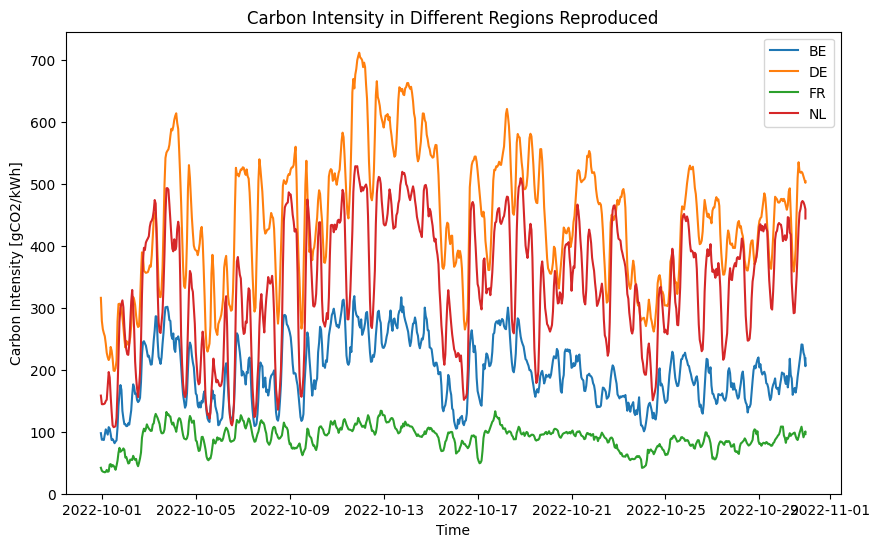

In [6]:
#Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_powerSource_BE = pd.read_parquet("output/repr_carbon_experiment/raw-output/0/seed=0/powerSource.parquet")

df_powerSource_DE = pd.read_parquet("output/repr_carbon_experiment/raw-output/1/seed=0/powerSource.parquet")

df_powerSource_FR = pd.read_parquet("output/repr_carbon_experiment/raw-output/2/seed=0/powerSource.parquet")

df_powerSource_NL = pd.read_parquet("output/repr_carbon_experiment/raw-output/3/seed=0/powerSource.parquet")

plt.figure(figsize=(10, 6))

timestamps = pd.to_datetime(df_powerSource_BE.timestamp_absolute, unit="ms")


plt.plot(timestamps, df_powerSource_BE["carbon_intensity"], label="BE")
plt.plot(timestamps, df_powerSource_DE["carbon_intensity"], label="DE")
plt.plot(timestamps, df_powerSource_FR["carbon_intensity"], label="FR")
plt.plot(timestamps, df_powerSource_NL["carbon_intensity"], label="NL")

plt.legend()
plt.xlabel("Time")
plt.ylim([0, None])
plt.ylabel("Carbon Intensity [gCO2/kWh]")
plt.title("Carbon Intensity in Different Regions Reproduced")

plt.show()

Text(0.5, 1.0, 'Carbon Intensity in Different Regions Extended')

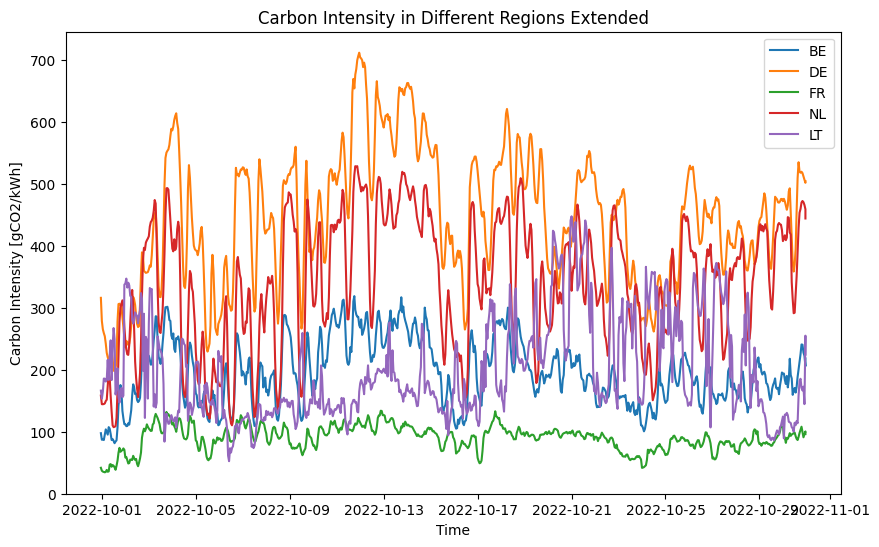

In [8]:
# Extended Visualization
df_powerSource_LT = pd.read_parquet("output/LT_experiment_carbon/raw-output/0/seed=0/powerSource.parquet")

plt.figure(figsize=(10, 6))

timestamps = pd.to_datetime(df_powerSource_BE.timestamp_absolute, unit="ms")


plt.plot(timestamps, df_powerSource_BE["carbon_intensity"], label="BE")
plt.plot(timestamps, df_powerSource_DE["carbon_intensity"], label="DE")
plt.plot(timestamps, df_powerSource_FR["carbon_intensity"], label="FR")
plt.plot(timestamps, df_powerSource_NL["carbon_intensity"], label="NL")
plt.plot(timestamps, df_powerSource_LT["carbon_intensity"], label="LT")

plt.legend()
plt.xlabel("Time")
plt.ylim([0, None])
plt.ylabel("Carbon Intensity [gCO2/kWh]")
plt.title("Carbon Intensity in Different Regions Extended")
